# [Kaggle] NLP Real of Not - Bert 를 이용해서 분류

kaggle url : https://www.kaggle.com/c/nlp-getting-started/overview

model url :
https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1

L-12 : hidden Layer 12개

H-768 : hidden size 768

A-12 : Attention Heads 12

### tensorflow hub 설치 (BERT 모델 다운로드)

In [1]:
!pip install tensorflow-hub

BERT tokenization 모듈 다운로드

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 9.5MB/s 


In [0]:
import tokenization

In [9]:
#tensorflow 1.x 버전 사용
#%tensorflow_version 1.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_hub as hub
import tensorflow as tf
import keras
from keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
root_path = '/content/drive/My Drive/'
file_path = '/content/drive/My Drive/MachineLearning_project/nlp-getting-started/'

### Data load

In [11]:
train_data = pd.read_csv( file_path + 'train.csv')
train_data[:5]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test_data = pd.read_csv( file_path + 'test.csv')
test_data[:5]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print(len(train_data))
print(len(test_data))

print(train_data['keyword'].isnull().sum())
print(test_data['keyword'].isnull().sum())
print(train_data['location'].isnull().sum())
print(test_data['location'].isnull().sum())

7613
3263
61
26
2533
1105


In [0]:
#특정 단어 포함된지 확인
te1 = train.loc[train['text'].str.contains('', na=False, case=False)].target.value_counts()
print(te1)

### EDA

target 0 : fake / 1 : real

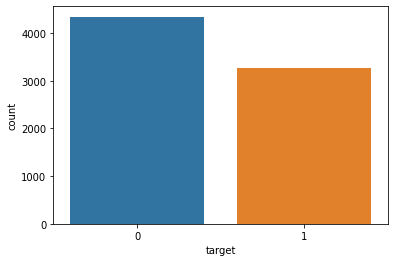

In [15]:
sns.countplot(x='target',data=train_data)

In [31]:
train_data['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

###NLTK 모듈 설치 및 설정


In [14]:
!pip install nltk

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words('english')

In [8]:
from wordcloud import STOPWORDS
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

###Data Cleaning

In [0]:
import re,string

In [0]:
def data_clean(txt) :
    txt = txt.lower()
    txt = re.sub('[\n]',' ',txt)
    #txt = re.sub('\?{2,}','?',txt)
    txt = re.sub('https?://\S+|www\.\S+', '', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    #txt = re.sub('\s{2,}',' ',txt)
    #txt = re.sub('\.{3,}','',txt)
                   
    return txt

In [0]:
def clean_text(text) :
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)    

def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [21]:
train_data['c_text'] = train_data['text'].apply(clean_text)
#train_data['c_text'] = train_data['text'].apply(data_clean)
train_data['c_text'] = train_data['c_text'].apply(remove_emoji)
train_data['c_text'] = train_data['c_text'].apply(remove_punct)
#train_data['c_text'] = train_data['c_text'].apply(remove_punctuations)
train_data['c_text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    ariaahrary TheTawniest The out of control wild...
7610                 M194 0104 UTC5km S of Volcano Hawaii
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: c_text, Length: 7613, dtype: object

In [0]:
# 영어 약어 정의
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact", "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [0]:
# 영어 줄여서 쓰는(수축) 단어들 정의 
contractions = { 
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he's": "he is",
  "how'd": "how did",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'll": "i will",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'll": "it will",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "must've": "must have",
  "mustn't": "must not",
  "needn't": "need not",
  "oughtn't": "ought not",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "she'd": "she would",
  "she'll": "she will",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "that'd": "that would",
  "that's": "that is",
  "there'd": "there had",
  "there's": "there is",
  "they'd": "they would",
  "they'll": "they will",
  "they're": "they are",
  "they've": "they have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'll": "we will",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "where'd": "where did",
  "where's": "where is",
  "who'll": "who will",
  "who's": "who is",
  "won't": "will not",
  "wouldn't": "would not",
  "you'd": "you would",
  "you'll": "you will",
  "you're": "you are",
  "thx"   : "thanks"
}

In [0]:
from nltk.tokenize import word_tokenize

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text): #약어를 원래 형태로 변형
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text    

def remove_contractions(text): #수축 단어 원래 형태로 변형
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [25]:
train_data['c_text'] = train_data['c_text'].apply(lambda x: convert_abbrev_in_text(x))
train_data['c_text'] = train_data['c_text'].apply(lambda x: remove_contractions(x))
train_data['c_text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    ariaahrary TheTawniest The out of control wild...
7610                 M194 0104 UTC5km S of Volcano Hawaii
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: c_text, Length: 7613, dtype: object

In [30]:
test_data['c_text'] = test_data['text'].apply(data_clean)
test_data['c_text']

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4           typhoon soudelor kills 28 in china and taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm in ri worse than last hurricane my citya...
3260                    green line derailment in chicago 
3261            meg issues hazardous weather outlook hwo 
3262    cityofcalgary has activated its municipal emer...
Name: c_text, Length: 3263, dtype: object

In [26]:
x_data = np.array(train_data['c_text'])
y_data = np.array(train_data['target'])

print(len(x_data))
print(len(y_data))

7613
7613


### Build BERT Model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Lambda, Input

In [0]:
# text에 스페셜 토큰 추가 후 토큰화
def bert_tokenizer(texts, tokenizer, max_len=1024) : 
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts :
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in nltk_stopwords] # 불용어 제거
    text = text[:max_len-2] # so that we can add cls and sep tokens
    input_seq = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(input_seq)

    tokens = tokenizer.convert_tokens_to_ids(input_seq)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_seq) + [0] * pad_len
    segment_ids = [0] * max_len

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


In [0]:
# BERT 모델 파인튜닝 부분
# bert_layer : bert임베딩 층
def build_model(bert_layer, max_len=1024) :
  input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

  pooled_output, seq_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = seq_output[:, 0, :] #Tensor("strided_slice:0", shape=(None, 768), dtype=float32)

  out = Dense(1, activation='sigmoid')(clf_output)

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

  return model

  #d1,d2 = bert_layer([input_word_ids, input_mask, segment_ids])
  #print(d1) #Tensor("keras_layer_1/Identity:0", shape=(None, 768), dtype=float32)
  #print(d2) #Tensor("keras_layer_1/Identity_1:0", shape=(None, None, 768), dtype=float32)
  #print(d2[:, 0, :]) #Tensor("strided_slice:0", shape=(None, 768), dtype=float32)


In [0]:
#bert_model_L12 = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1"
bert_model_L12 = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1"
bert_model_un_L12 = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_model_un_L24 = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(bert_model_un_L12, trainable=True)

In [0]:
#build_model(bert_layer,max_len=512)

Tensor("keras_layer_1/Identity:0", shape=(None, 768), dtype=float32)
Tensor("keras_layer_1/Identity_1:0", shape=(None, None, 768), dtype=float32)
Tensor("strided_slice:0", shape=(None, 768), dtype=float32)


In [0]:
#build_model(bert_layer,max_len=512)

Tensor("keras_layer_3/Identity:0", shape=(None, 768), dtype=float32)
Tensor("keras_layer_3/Identity_1:0", shape=(None, None, 768), dtype=float32)
Tensor("strided_slice_3:0", shape=(None, 768), dtype=float32)
Tensor("strided_slice_4:0", shape=(None, 768), dtype=float32)
Tensor("strided_slice_5:0", shape=(None, 768), dtype=float32)


In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [0]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_input = bert_tokenizer(x_data, tokenizer, max_len=160)
#test_input = bert_tokenizer(x_test, tokenizer, max_len=160)

In [42]:
train_input

(array([[  101, 15616,  3114, ...,     0,     0,     0],
        [  101,  3224,  2543, ...,     0,     0,     0],
        [  101,  3901,  2356, ...,     0,     0,     0],
        ...,
        [  101, 23290,  2683, ...,     0,     0,     0],
        [  101,  2610, 11538, ...,     0,     0,     0],
        [  101,  6745,  5014, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [43]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
model_BERT.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
train_history = model_BERT.fit(train_input, y_data,
    validation_split = 0.2,
    epochs = 3, # recomended 3-5 epochs
    batch_size = 16 #32
)

Epoch 1/3
381/381 [==============================] - 212s 556ms/step - loss: 0.7313 - accuracy: 0.5567 - val_loss: 0.7162 - val_accuracy: 0.5345
Epoch 2/3
381/381 [==============================] - 210s 552ms/step - loss: 0.6849 - accuracy: 0.5695 - val_loss: 0.7047 - val_accuracy: 0.5345
Epoch 3/3
158/381 [===========>..................] - ETA: 1:52 - loss: 0.6883 - accuracy: 0.5676

KeyboardInterrupt: ignored

In [0]:
print("\n 테스트 정확도: %.4f" % (model_BERT.evaluate(test_input, y_test)[1]))

35/35 [==============================] - 7s 197ms/step - loss: 0.4001 - accuracy: 0.8700

 테스트 정확도: 0.8700
